## 과제 1: 장르별 영화 트렌드 및 흥행 성공 요인 분석
최근 20년간 영화 장르별 트렌드 변화를 분석하고, 각 장르에서 흥행에 성공한 영화들의 공통 요소(예산, 런타임, 출연진, 개봉 시기 등)를 파악하세요.

,count,share_%
genres,,
드라마,51,20.32
액션,44,17.53
스릴러,32,12.75
코미디,21,8.37
범죄,16,6.37
모험,13,5.18
공포,13,5.18
역사,10,3.98
미스터리,10,3.98


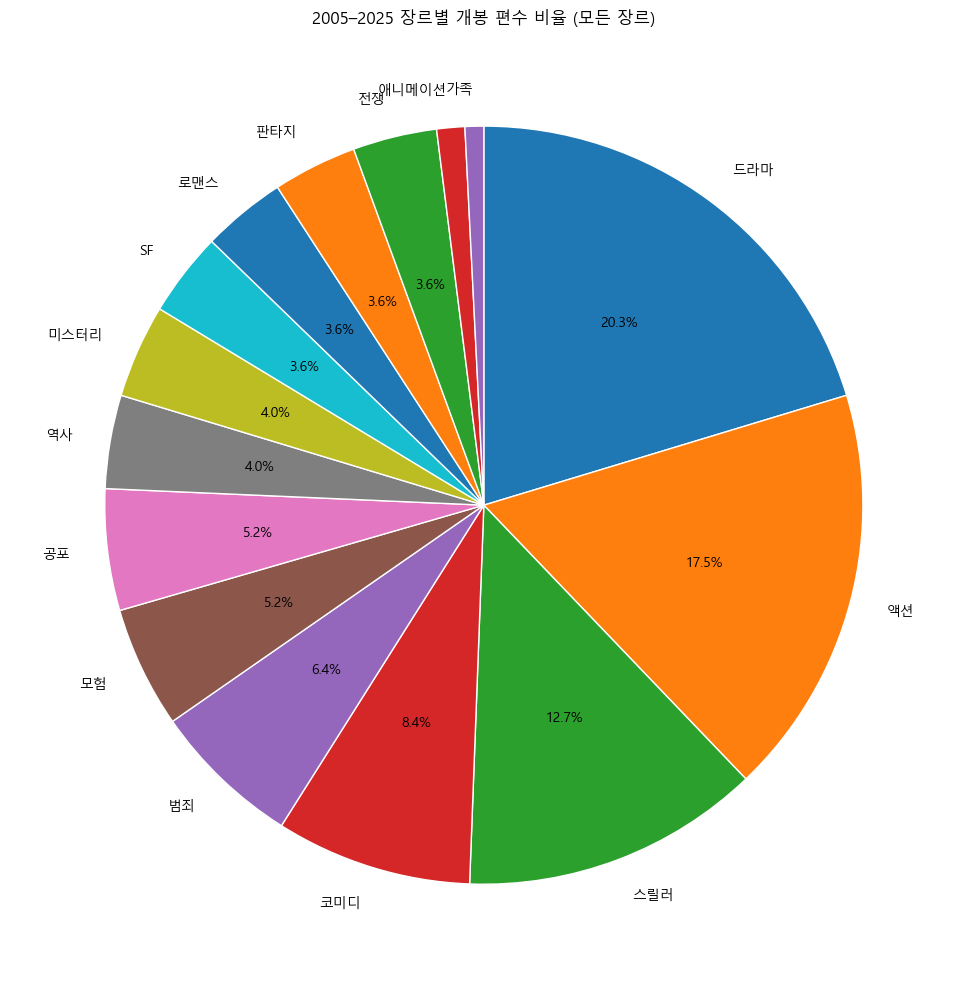

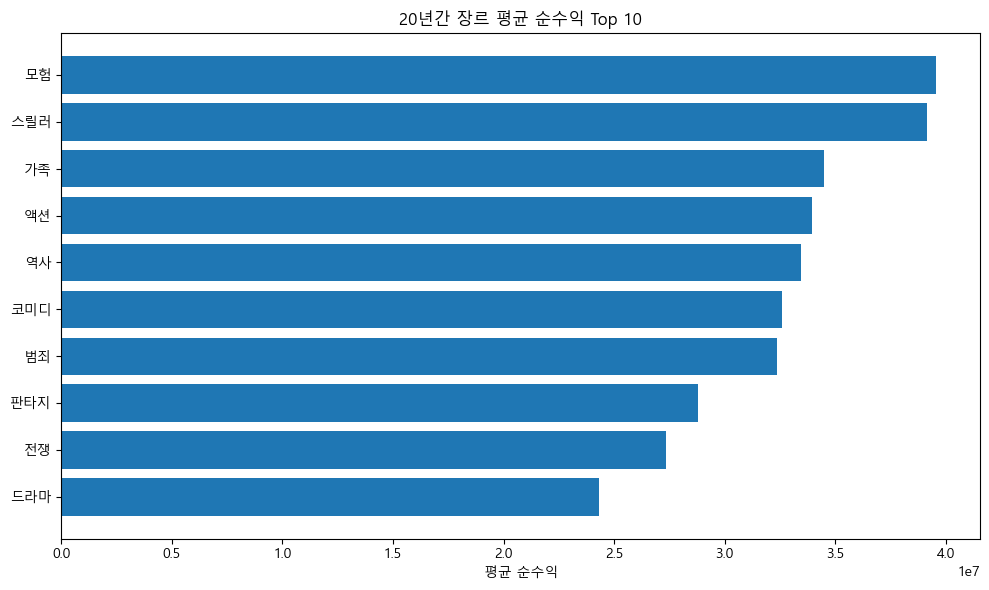

,avg_net_profit
genres,
모험,3.956417e+07
스릴러,3.914828e+07
가족,3.446994e+07
액션,3.394017e+07
역사,3.342742e+07
코미디,3.259726e+07
범죄,3.235738e+07
판타지,2.881169e+07
전쟁,2.733605e+07


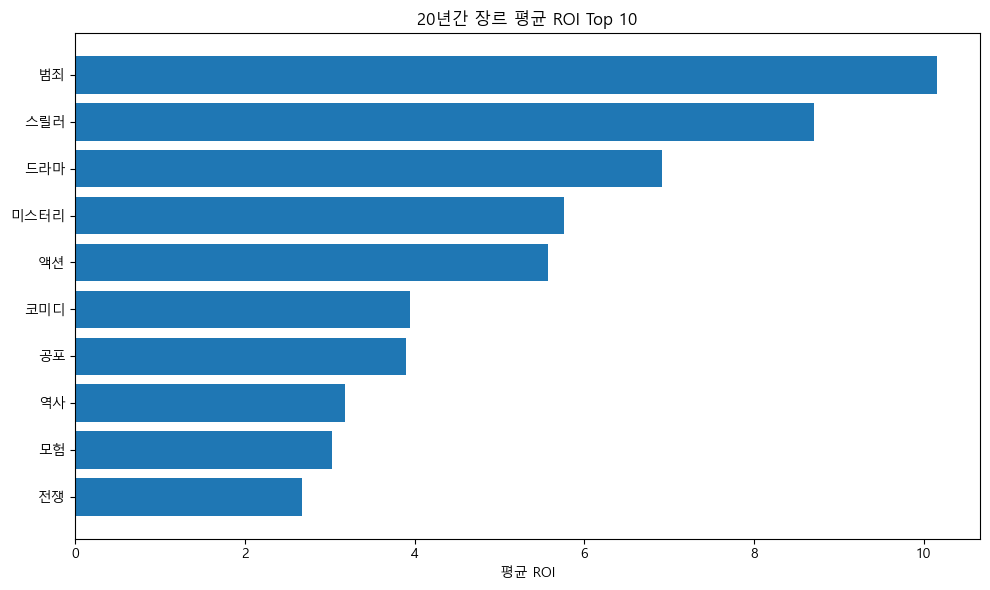

,avg_ROI
genres,
범죄,10.157239
스릴러,8.706589
드라마,6.911812
미스터리,5.762966
액션,5.571507
코미디,3.946763
공포,3.898508
역사,3.179133
모험,3.032127


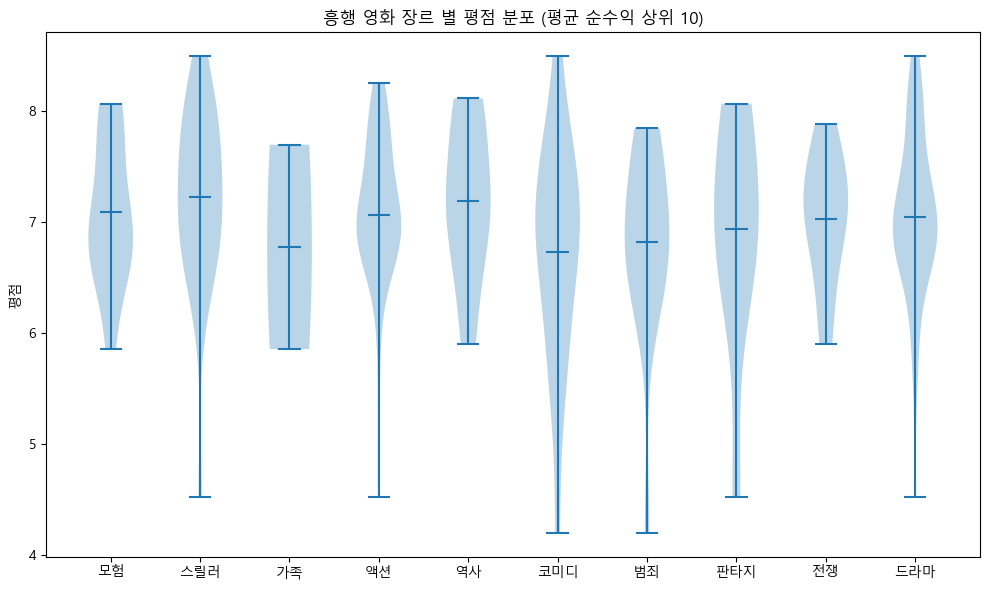

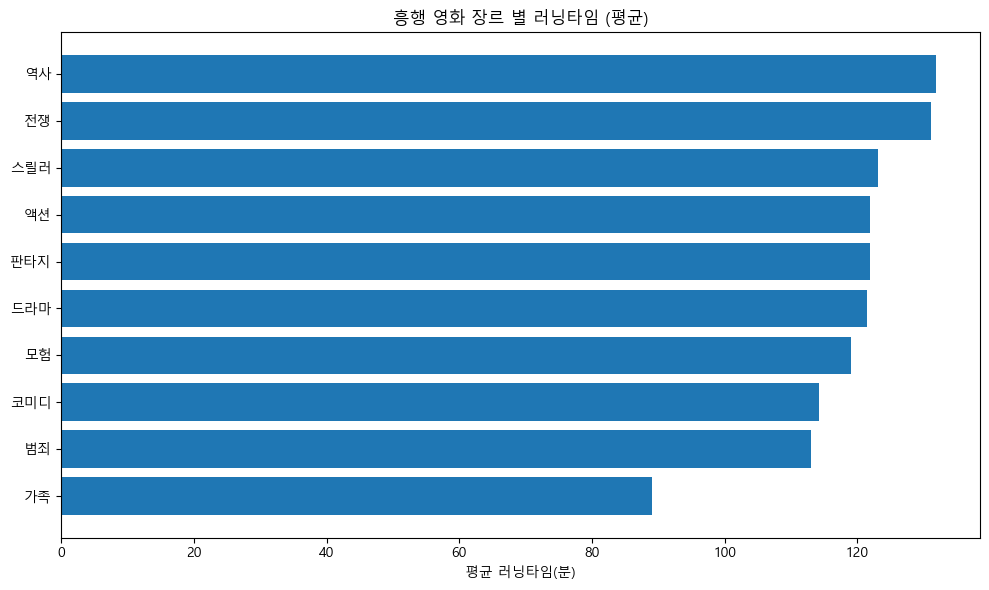

In [ ]:
# === 설정/불러오기 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

PATH_EXP = "./data_processed/tmdb_kr_theatrical_clean_exploded.csv"
df = pd.read_csv(PATH_EXP)

# === 1) 20년간 장르 편수: 파이 차트(모든 장르) ===
genre_counts = (df.groupby("genres")["movie_id"]
                .nunique()
                .sort_values(ascending=False))

genre_share = (genre_counts / genre_counts.sum() * 100).round(2)
display(pd.DataFrame({"count": genre_counts, "share_%": genre_share}))

plt.figure(figsize=(10,10))
def autopct_pct_only(pct, threshold=2.0):
    return f"{pct:.1f}%" if pct >= threshold else ""
plt.pie(
    genre_counts.values,
    labels=genre_counts.index,
    autopct=lambda p: autopct_pct_only(p, threshold=2.0),
    startangle=90, counterclock=False, wedgeprops=dict(edgecolor="white")
)
plt.title("2005–2025 장르별 개봉 편수 비율 (모든 장르)")
plt.tight_layout(); plt.show()

# === 유틸: Top-N 막대 그래프 함수 ===
def bar_top(series, title, xlabel, topn=10, sort_desc=True, log_x=False):
    s = series.dropna()
    s = s.sort_values(ascending=not sort_desc).head(topn)
    plt.figure(figsize=(10,6))
    plt.barh(s.index, s.values)
    if log_x:
        plt.xscale("log")
    plt.gca().invert_yaxis()
    plt.title(title); plt.xlabel(xlabel)
    plt.tight_layout(); plt.show()
    return s

# ---------------------------------------------
# 20년간 '평균 순수익' Top 10  ▶︎ 흥행 장르 선정 기준
# ---------------------------------------------
df["net_profit"] = df["revenue"] - df["budget"]   # 순수익
avg_net_by_genre = df.groupby("genres")["net_profit"].mean()
top_net = bar_top(
    avg_net_by_genre,
    title="20년간 장르 평균 순수익 Top 10",
    xlabel="평균 순수익",
    topn=10, sort_desc=True, log_x=False  # 순수익은 음수 가능 → log 축 사용하지 않음
)
display(top_net.to_frame("avg_net_profit"))

# 흥행 장르 리스트(평균 순수익 상위 10)
hit_genres = top_net.index.tolist()

# ---------------------------------------------
# 20년간 장르 '평균 ROI' Top10 (막대)
# ---------------------------------------------
avg_roi_by_genre = df.groupby("genres")["roi"].mean()
top_roi = bar_top(
    avg_roi_by_genre,
    title="20년간 장르 평균 ROI Top 10",
    xlabel="평균 ROI",
    topn=10, sort_desc=True, log_x=False
)
display(top_roi.to_frame("avg_ROI"))

# ---------------------------------------------
# '흥행 영화 장르'의 평점 분포 (바이올린)
# ---------------------------------------------
plt.figure(figsize=(10,6))
sel = hit_genres  # 평균 순수익 상위 10개 장르
data = [df.loc[df["genres"]==g, "vote_average"].dropna() for g in sel]
plt.violinplot(data, showmeans=True)
plt.xticks(range(1, len(sel)+1), sel, rotation=0)
plt.title("흥행 영화 장르 별 평점 분포 (평균 순수익 상위 10)")
plt.ylabel("평점")
plt.tight_layout(); plt.show()

# ---------------------------------------------
# '흥행 영화 장르'의 러닝타임 (막대)
# ---------------------------------------------
avg_rt_hit = (df[df["genres"].isin(hit_genres)]
              .groupby("genres")["runtime"].mean()
              .sort_values(ascending=False))
_ = bar_top(
    avg_rt_hit,
    title="흥행 영화 장르 별 러닝타임 (평균)",
    xlabel="평균 러닝타임(분)",
    topn=len(hit_genres), sort_desc=True, log_x=False
)
